In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import (
    StructType, StructField,
    StringType, IntegerType
)
from pyspark.sql.functions import col, count, sum as spark_sum, log2, avg
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm

spark = (
    SparkSession.builder
    .appName("DiversidadAperturas")
    .getOrCreate()
)


df = spark.read.csv(
    r"C:\Users\migue\OneDrive\Desktop\Lichess_2013_2014_Complete.csv",
    header=True,
    inferSchema=True
) 

df_white = df.filter(
    F.col("WhiteName").isNotNull() &
    F.col("WhiteElo").isNotNull() &
    F.col("Opening").isNotNull()
).select("WhiteName", "WhiteElo", "Opening")

# cache porque lo usamos varias veces
df_white = df_white.cache()


#ELO promedio por jugador blanco (WhiteName)

elo_promedio = (
    df_white
    .groupBy("WhiteName")
    .agg(F.avg("WhiteElo").alias("AvgWhiteElo"),
         F.count("*").alias("GamesAsWhite"))
    .orderBy(F.desc("AvgWhiteElo"))
)

#Asociar aperturas con cada jugador blanco (Simplemente mostramos las filas Player-Opening-Elo)
jugador_aperturas = df_white.select(
    F.col("WhiteName").alias("Player"),
    F.col("WhiteElo").alias("Elo"),
    F.col("Opening")
)

#Frecuencias absolutas y relativas por jugador y apertura

#Frecuencias absolutas
freq_abs = (
    jugador_aperturas
    .groupBy("Player", "Opening")
    .agg(F.count("*").alias("freq_abs"))
    .orderBy("Player", F.desc("freq_abs"))
)

#Total de aperturas por jugador (para calcular relativas)
totales_por_player = (
    freq_abs
    .groupBy("Player")
    .agg(F.sum("freq_abs").alias("total_aperturas"))
)

# Unir y calcular frecuencia relativa
freq_rel = (
    freq_abs.join(totales_por_player, on="Player", how="inner")
    .withColumn("freq_rel", F.col("freq_abs") / F.col("total_aperturas"))
    .orderBy("Player", F.desc("freq_rel"))
)

print("\n=== Frecuencias relativas (Player, Opening, freq_rel) ===")
freq_rel.show(80, truncate=False)


=== Frecuencias relativas (Player, Opening, freq_rel) ===
+--------------------+------------------------------------------------------------------+--------+---------------+--------------------+
|Player              |Opening                                                           |freq_abs|total_aperturas|freq_rel            |
+--------------------+------------------------------------------------------------------+--------+---------------+--------------------+
|-------------1      |Nimzo-Larsen Attack                                               |1       |2              |0.5                 |
|-------------1      |King's Pawn Game: Macleod Attack                                  |1       |2              |0.5                 |
|-----------0        |Ruy Lopez: Cozio Defense                                          |1       |1              |1.0                 |
|--------o0l0o-------|Mieses Opening: Reversed Rat                                      |1       |1              |1.0        

In [2]:
# ---------------------------
# Entropía de Shannon por jugador utilizando freq_rel
#    H = - Σ p * log2(p)
#   (usamos log base e / log(2) para compatibilidad)
# ---------------------------
# Evitar log(0) (freq_rel no debería tener 0) — pero por seguridad:
freq_rel_nonzero = freq_rel.filter(F.col("freq_rel") > 0)

# term = - p * log2(p) = - p * (log(p) / log(2))
entropy_terms = freq_rel_nonzero.withColumn(
    "term",
    - F.col("freq_rel") * (F.log(F.col("freq_rel")) / F.log(F.lit(2.0)))
)

entropy = (
    entropy_terms
    .groupBy("Player")
    .agg(F.sum("term").alias("ShannonEntropy"))
    .orderBy(F.desc("ShannonEntropy"))
)

print("\n=== Entropía de Shannon por Jugador ===")
entropy.show(80, truncate=False)


=== Entropía de Shannon por Jugador ===
+--------------------+------------------+
|Player              |ShannonEntropy    |
+--------------------+------------------+
|1929                |8.396324476192325 |
|emperator           |8.372622987583823 |
|Porfirios           |8.358817507202371 |
|misaaa              |8.324553568916295 |
|ZeruHmyz            |8.251884594283677 |
|Argonn3007          |8.244243277129206 |
|tibi                |8.223068578658792 |
|oxymoron21st        |8.181484769316503 |
|assssss22133        |8.145121265297885 |
|RONNER              |8.14430516813766  |
|unpredictable       |8.116677904939566 |
|arina1999           |8.102992957009649 |
|michaeljmeadows     |8.10076559471805  |
|outlier             |8.09580977403312  |
|Petrovich63         |8.030731575581239 |
|kicmak              |8.003696613664394 |
|Eggplant            |7.997977082348244 |
|norimyxxxo          |7.9973885761371495|
|Sinan               |7.988391653748217 |
|shaf                |7.97185981648

In [3]:
#Asociar Entropía con ELO promedio
#elo_promedio tiene columna WhiteName, la renombramos a Player para el join
elo_promedio_player = elo_promedio.withColumnRenamed("WhiteName", "Player")

resultado_final = (
    entropy.join(elo_promedio_player, on="Player", how="inner")
    .select("Player", "AvgWhiteElo", "GamesAsWhite", "ShannonEntropy")
    .orderBy(F.desc("AvgWhiteElo"))
)


# Filtrar solo partidas ganadas por el jugador que juega con blancas
victorias_blancas = (
    df.filter(
        (F.col("WhiteName").isNotNull()) &
        (F.col("Winner") == "White")      # ganador fue el jugador blanco
    )
    .groupBy("WhiteName")
    .agg(F.count("*").alias("VictoriasComoBlancas"))
)

# Renombrar columna para emparejar con Player
victorias_blancas = victorias_blancas.withColumnRenamed("WhiteName", "Player")

# Unir ENTROPÍA + ELO + VICTORIAS
resultado_con_victorias = (
    resultado_final.join(victorias_blancas, on="Player", how="left")
    .fillna({"VictoriasComoBlancas": 0})
    .orderBy(F.desc("AvgWhiteElo"))
)

print("\n=== Entropía + ELO + Victorias (Resultado final) ===")
resultado_con_victorias.show(100, truncate=False)


=== Entropía + ELO + Victorias (Resultado final) ===
+-------------------+------------------+------------+------------------+--------------------+
|Player             |AvgWhiteElo       |GamesAsWhite|ShannonEntropy    |VictoriasComoBlancas|
+-------------------+------------------+------------+------------------+--------------------+
|thinkabit          |2828.0            |1           |0.0               |1                   |
|Uereqas            |2708.0            |1           |0.0               |1                   |
|whysoserious       |2705.148305084746 |472         |6.65929345099061  |430                 |
|GoodLuckBro        |2616.4767441860463|86          |3.7282137337437957|70                  |
|mrunstoppable      |2615.3508771929824|114         |3.648361063888522 |100                 |
|Flamingokvintetten |2608.0            |1           |0.0               |0                   |
|QAZ22              |2607.0            |1           |0.0               |0                   |
|milac

<Figure size 1000x600 with 0 Axes>

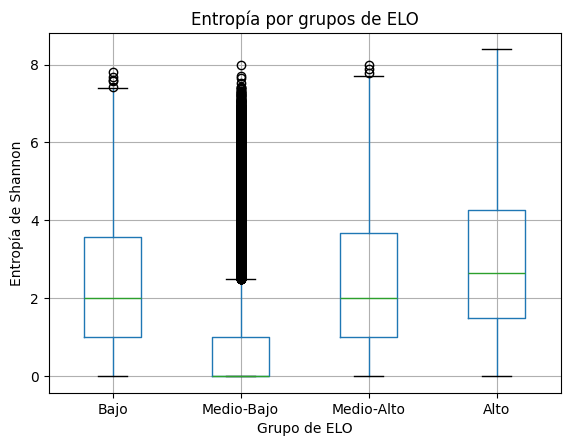

In [5]:
# Convertir a Pandas
pdf1 = resultado_con_victorias.select("AvgWhiteElo", "ShannonEntropy").toPandas()
pdf1 = pdf1.dropna()

pdf1["ELO_bin"] = pd.qcut(pdf1["AvgWhiteElo"], 4, labels=["Bajo", "Medio-Bajo", "Medio-Alto", "Alto"])

plt.figure(figsize=(10,6))
pdf1.boxplot(column="ShannonEntropy", by="ELO_bin")
plt.title("Entropía por grupos de ELO")
plt.suptitle("")
plt.xlabel("Grupo de ELO")
plt.ylabel("Entropía de Shannon")
plt.grid(True)
plt.show()

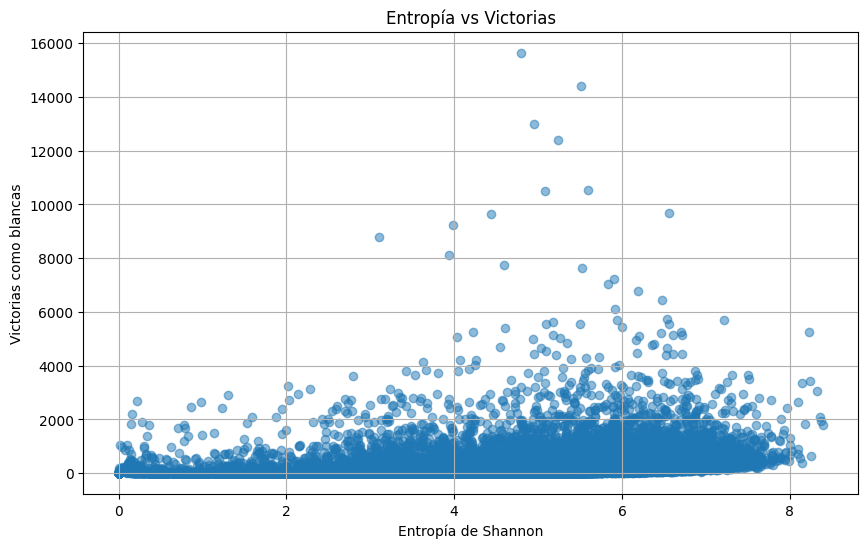

In [6]:
pdf2 = resultado_con_victorias.select("VictoriasComoBlancas", "ShannonEntropy").toPandas()
pdf2 = pdf2.dropna()

plt.figure(figsize=(10,6))
plt.scatter(pdf2["ShannonEntropy"], pdf2["VictoriasComoBlancas"], alpha=0.5)
plt.xlabel("Entropía de Shannon")
plt.ylabel("Victorias como blancas")
plt.title("Entropía vs Victorias")
plt.grid(True)
plt.show()